# **Прогнозирование концентрации метана. Реализация на scikit-learn, MLPRegressor.**

## Модель: многослойный персептрон с 1 скрытым слоем. </br>
### Конфигурации:
1. 28 - 57 - 1. $K=2N\ +\ 1$.</br>
2. 28 - 114 - 1. $K=2(2N+1)$.</br>
3. 28 - 15 - 1. $K=\frac{N+M}{2}$.</br>

## Функции активации нейронов (для скрытого и выходного слоёв соответственно):
* Гиперболический тангенс, линейная
* Сигмоидальная, линейная
* Линейная, линейная

## Подготовка данных:
1. Извлечение данных из оригинального файла methane_data/methane_data.csv ([ссылка на набор данных](https://data.mendeley.com/datasets/yd7vw4c5mk/1)) с датами от **2014-03-29 13:44:57** по **2014-04-08 13:15:56** (858.660 строк).
2. Добавление в набор данных поля *'mm256_forecast'*, данные для которого - поле *'mm256'* из строки с номером на 900 больше текущей.
3. Применение экспоненциального сглаживания для данных всех полей, кроме полей *'id'*, *'moment'* дважды.  Коэффициент для первого сглаживания **α = 0,1**. Коэффициент для второго сглаживания **α = 0,01**.
4. Разделение извлечённых данных случайным образом на два набора данных: *'train_data'* - для обучения, составляет 70% от набора данных из пункта 1. *'test_data'* - для тестирования, составляет 30% от набора данных из пункта 1.
5. Сеть обучается на *'train_data'*, оценка сети происходит на данных *'test_data'*, конечный прогноз происходит для всего набора данных.

## Набор данных:
* Входные поля: an311, an422, an423, tp1721, rh1722, ba1723, tp1711, rh1712, ba1713, mm252, mm261, mm262, mm263, mm264, mm256, mm211, cm861, cr863, p_864, tc862, wm868, amp1_ir, amp2_ir, dmp3_ir, dmp4_ir, amp5_ir, f_side, v - все значения текущие
* Целевое значение: mm256_predict - значение mm256, взятое из момента времени на 900 секунд позже

## Оценка качества модели (используемые метрики):
* Коэффициент детерминации R²
* Среднеквадратичная ошибка MSE (Mean Squared Error)
* Корень из среднеквадратичной ошибки RMSE (Root Mean Squared Error)
* Cредняя абсолютная ошибка MAE (Mean Absolute Error)
* Средняя абсолютная процентная ошибка MAPE (Mean Absolute Percentage Error)

In [ ]:
# @title Загрузка библиотек { vertical-output: false}

!pip install matplotlib &> /dev/null
!pip install numpy &> /dev/null
!pip install pandas &> /dev/null
!pip install -U scikit-learn &> /dev/null
!pip install seaborn &> /dev/null
!pip install tabulate &> /dev/null

In [ ]:
# @title Подключение пакетов и модулей { vertical-output: false}

import requests
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from scipy.stats import sem
from typing import Optional
from datetime import datetime, timedelta

In [ ]:
# @title Объявление параметров { vertical-output: false}

factors = [
    'an311', 'an422', 'an423', 'tp1721', 'rh1722', 'ba1723', 'tp1711', 'rh1712', 'ba1713',
    'mm252', 'mm261', 'mm262', 'mm263', 'mm264', 'mm256', 'mm211', 'cm861', 'cr863', 'p_864',
    'tc862', 'wm868', 'amp1_ir', 'amp2_ir', 'dmp3_ir', 'dmp4_ir', 'amp5_ir', 'f_side', 'v'
]

factors_added = ['mm256_predicted'] + factors

new_factors = factors_added + ['mm256_forecast']

factors_new = [
    'an311', 'an422', 'an423', 'tp1721', 'rh1722', 'ba1723', 'tp1711', 'rh1712', 'ba1713',
    'mm252', 'mm261', 'mm262', 'mm263', 'mm264', 'mm256', 'mm211', 'cm861', 'cr863', 'p_864',
    'tc862', 'wm868', 'amp1_ir', 'amp2_ir', 'dmp3_ir', 'dmp4_ir', 'amp5_ir', 'f_side', 'v', 'mm256_forecast'
]

new_factors_2 = [ 'id', 'moment',
    "an311", "an422", "an423", "tp1721", "rh1722", "ba1723", "tp1711", "rh1712", "ba1713",
    "mm252", "mm261", "mm262", "mm263", "mm264", "mm256", "mm211", "cm861", "cr863", "p_864",
    "tc862", "wm868", "amp1_ir", "amp2_ir", "dmp3_ir", "dmp4_ir", "amp5_ir", "f_side", "v", "mm256_forecast"
]

target = 'mm256_predicted'

start_time = pd.Timestamp("2014-03-29 13:44:57")
end_time = pd.Timestamp("2014-04-08 13:15:56")

In [ ]:
# @title Используемые функции { vertical-output: false}

def smooth_values(alpha: float, data_set: pd.DataFrame, factors: list):
    smoothed_data = data_set[factors].ewm(alpha=alpha, adjust=False).mean()
    smoothed_data["id"] = data_set["id"]
    smoothed_data["moment"] = data_set["moment"]
    columns = ["id", "moment"] + factors
    smoothed_data = smoothed_data[columns]

    return smoothed_data


def plot_dataset_values(
        start_time: pd.Timestamp,
        end_time: pd.Timestamp,
        alpha: float,
        factor_name: str,
        title: str,
        data_set_1: pd.DataFrame,
        data_set_2: Optional[pd.DataFrame] = None,
):
    meter_name = factor_name.lower()

    data_set_1["moment"] = pd.to_datetime(data_set_1["moment"])
    data_set_1_filtered = data_set_1[(data_set_1["moment"] >= start_time) & (data_set_1["moment"] <= end_time)]

    plt.rcParams.update({"font.size": 20})
    plt.figure(figsize=(35, 15))

    plt.plot(
        data_set_1_filtered['moment'],
        data_set_1_filtered[meter_name],
        '-',
        linewidth=4,
        color='deepskyblue',
        alpha=1.0,
        marker='',
        markerfacecolor='white',
        markersize=0,
        markevery=0,
        label=f'Значения датчика {meter_name.upper()}',
    )

    if data_set_2 is not None:
        data_set_2["moment"] = pd.to_datetime(data_set_2["moment"])
        data_set_2_filtered = data_set_2[(data_set_2["moment"] > start_time) & (data_set_2["moment"] < end_time)]

        plt.plot(
            data_set_2_filtered["moment"],
            data_set_2_filtered[meter_name],
            linewidth=4,
            color='red',
            alpha=1.0,
            marker='',
            markerfacecolor='white',
            markersize=0,
            markevery=0,
            label=f'Сглаженные значения {meter_name.upper()} , α = {alpha}',
        )

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=30))
    plt.legend()
    plt.title(f"{title} {meter_name.upper()} ({start_time} - {end_time})")
    plt.xlabel("Время")
    plt.ylabel(f"Значение {meter_name.upper()}")
    plt.gcf().autofmt_xdate()
    fig = plt.gcf()
    fig.autofmt_xdate(rotation=90)
    plt.tight_layout()
    plt.show()


def plot_forecasted_values(
        real_value: str,
        forecast_value: str,
        data_set: pd.DataFrame,
        start_time: pd.Timestamp,
        end_time: pd.Timestamp,
):
    data_set["moment"] = pd.to_datetime(data_set["moment"])
    final_data_filtered = data_set[(data_set["moment"] >= start_time) & (data_set["moment"] <= end_time)]

    plt.rcParams.update({"font.size": 20})
    plt.figure(figsize=(15, 10))
    plt.plot(
        final_data_filtered['moment'] + timedelta(minutes=15),
        final_data_filtered[real_value],
        '-',
        linewidth=2,
        color='deepskyblue',
        alpha=1.0,
        marker='',
        markerfacecolor='white',
        markersize=0,
        markevery=0,
        label=f'Реальные значения датчика MM256',
    )
    plt.plot(
        final_data_filtered['moment']+ timedelta(minutes=15),
        final_data_filtered[forecast_value],
        '-',
        linewidth=1,
        color='red',
        alpha=1.0,
        marker='',
        markerfacecolor='white',
        markersize=0,
        markevery=0,
        label="Спрогнозированные значения датчика MM256",
    )
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=30))
    plt.legend()
    plt.title("Реальные и спрогнозированные значения датчика 'MM256'")
    plt.xlabel("Время")
    plt.ylabel(f"Концентрация %CH₄")
    plt.gcf().autofmt_xdate()
    fig = plt.gcf()
    fig.autofmt_xdate(rotation=90)
    plt.tight_layout()
    plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.680), ncol=2, prop={'size': 15})
    plt.show()


def plot_scatter(data_set: pd.DataFrame):
    data_set = data_set.iloc[::500, :]
    plt.rcParams.update({"font.size": 20})
    plt.figure(figsize=(15, 10))
    max_mm256 = data_set['mm256_predicted'].max()
    max_mm256_forecast = data_set['mm256_forecast'].max()
    max_value = data_set[['mm256_predicted', 'mm256_forecast']].max().max()
    plt.plot([0,max_value], [0,max_value], color = 'deeppink')
    plt.scatter(data_set['mm256_predicted'], data_set['mm256_forecast'], alpha = 0.9, color = 'blue', label = "точки (x - реальное значение, y - спрогнозированное значение)")
    plt.title('Диаграмма рассеяния для mm256_predicted и mm256_forecast\n(часть значений)')
    plt.legend(bbox_to_anchor=(0.0, -0.2, 0, 0), loc=3, ncol=1, prop={'size': 20})
    plt.xlabel('x - реальные значения датчика')
    plt.ylabel('y - спрогнозированные значения датчика')
    plt.show()


def plot_boxplot(data_set: pd.DataFrame, factors: list):
    num_rows = int(np.ceil(len(factors) / 4))
    num_cols = min(4, len(factors))

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    for i, id_value in enumerate(factors):
         row_idx = i // num_cols
         col_idx = i % num_cols

         sns.boxplot(data_set[id_value], ax=axs[row_idx, col_idx], color='deepskyblue', linecolor='black',legend='full')
         axs[row_idx, col_idx].set_title(f'Диаграмма\nвыбросов\nдля датчика\n{id_value.upper()}')
         axs[row_idx, col_idx].set_xlabel(id_value.upper())
         axs[row_idx, col_idx].set_ylabel('Значение датчика')

    for i in range(len(factors), num_rows * num_cols):
          row_idx = i // num_cols
          col_idx = i % num_cols
          fig.delaxes(axs[row_idx, col_idx])

    plt.tight_layout()
    plt.show()


def get_metrics(data_set: pd.DataFrame):
    numeric_columns = data_set.drop(['id', 'moment'], axis=1)
    stats = numeric_columns.describe()
    stats = stats.round(3)
    stats.columns = stats.columns.str.upper()

    stats.index = [
        'Количество',
        'Среднее',
        'Стандартное отклонение',
        'Минимум',
        '25-й перцентиль',
        'Медиана',
        '75-й перцентиль',
        'Максимум'
    ]

    df_stats = pd.DataFrame(stats)

    return df_stats


def plot_values(
        factor_name: str,
        data_set: pd.DataFrame
):
    factor_name = factor_name.lower()
    data_set["moment"] = pd.to_datetime(data_set["moment"])

    plt.rcParams.update({"font.size": 20})
    plt.figure(figsize=(35, 15))
    plt.plot(
        data_set['moment'],
        data_set[factor_name],
        '-',
        linewidth=4,
        color='deepskyblue',
        alpha=1.0,
        marker='',
        markerfacecolor='white',
        markersize=0,
        markevery=0,
        label='Значения с датчика',
    )
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=30))
    plt.legend()
    plt.title(f"{factor_name.upper()}")
    plt.xlabel("Время")
    plt.ylabel(f"Значение {factor_name.upper()}")
    plt.gcf().autofmt_xdate()
    fig = plt.gcf()
    fig.autofmt_xdate(rotation=90)
    plt.tight_layout()
    plt.show()


def clean_ba1713(data_set: pd.DataFrame, factors: list):

    for field in factors:
        Q1 = data_set[field].quantile(0.25)
        Q3 = data_set[field].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        for index, x in data_set[field].items():
            if x < lower_bound or x > upper_bound:
                if x < lower_bound and index > 0:
                    try:
                         data_set.at[index, field] = data_set.at[index-1, field]
                    except:
                         data_set.at[index, field] = data_set.at[index+1, field]

    return data_set


def clean_mm252(data_set: pd.DataFrame, factors: list):
    for field in factors:
        mean_value = data_set[field].mean()
        data_set[field] = data_set[field].apply(lambda x: mean_value + np.random.uniform(0, np.sqrt(mean_value)) if x <= 0.0 or x >= 2.0  else x)
        # data_set[field] = data_set[field].apply(lambda x: mean_value + np.random.uniform(0, np.sqrt(mean_value)) if x >= 2.0  else x)

        # Q1 = data_set[field].quantile(0.25)
        # Q3 = data_set[field].quantile(0.75)
        # IQR = Q3 - Q1
        # lower_bound = Q1 - 1.5 * IQR
        # upper_bound = Q3 + 1.5 * IQR

        # for index, x in data_set[field].items():
        #     if x < lower_bound or x > upper_bound:
        #         if x < lower_bound and index > 0:
        #             try:
        #                  data_set.at[index, field] = mean_value + np.random.uniform(0, np.sqrt(mean_value))
        #             except:
        #                  data_set.at[index, field] = mean_value + np.random.uniform(0, np.sqrt(mean_value))
        #         if x > upper_bound and index > 0:
        #             try:
        #                  data_set.at[index, field] = mean_value + np.random.uniform(0, np.sqrt(mean_value))
        #             except:
        #                  data_set.at[index, field] = mean_value + np.random.uniform(0, np.sqrt(mean_value))

    return data_set


def clean_cm861(data_set: pd.DataFrame, factors: list):
    for field in factors:
        standard_error = sem(data_set[field])
        mean_value = data_set[field].mean()
        data_set[field] = data_set[field].apply(lambda x: mean_value + np.random.uniform(0, np.sqrt(mean_value)) if x <= 0.0 else x)

        for index, x in data_set[field].items():
            if x > mean_value + 1.5 * standard_error:
                try:
                    data_set.at[index, field] = mean_value + np.random.uniform(0, np.sqrt(mean_value))
                except:
                    data_set.at[index, field] = mean_value + np.random.uniform(0, np.sqrt(mean_value))

    return data_set


def clean_cr863(data_set: pd.DataFrame, factors: list):
    for field in factors:
        mean_value = data_set[field].mean()
        data_set[field] = data_set[field].apply(lambda x: mean_value + np.random.uniform(0, np.sqrt(mean_value)) if x <= 0.0 else x)

        Q1 = data_set[field].quantile(0.25)
        Q3 = data_set[field].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 0.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        for index, x in data_set[field].items():
            if x < lower_bound or x > upper_bound:
                if x < lower_bound and index > 0:
                    try:
                         data_set.at[index, field] = mean_value + np.random.uniform(0, np.sqrt(mean_value))
                    except:
                         data_set.at[index, field] = mean_value + np.random.uniform(0, np.sqrt(mean_value))
                if x > upper_bound and index > 0:
                    try:
                         data_set.at[index, field] = mean_value + np.random.uniform(0, np.sqrt(mean_value))
                    except:
                         data_set.at[index, field] = mean_value + np.random.uniform(0, np.sqrt(mean_value))

    return data_set


def clean_v(data_set: pd.DataFrame, factors: list):
    for field in factors:
        data_set[field] = data_set[field].apply(lambda x: 3.0 if x < 3.0 else x)

    return data_set


def swap_outliers(data_set: pd.DataFrame, factors: list):

    for field in factors:
        median_value = data_set[field].median()

        Q1 = data_set[field].quantile(0.25)
        Q3 = data_set[field].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data_set[field] = data_set[field].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)

    return data_set

def get_net(url: str, given_name: str):
    response = requests.get(url)
    response.raise_for_status()
    with open(given_name, "wb") as f:
          f.write(response.content)
    net = pickle.load(open(given_name, 'rb'))

    return net

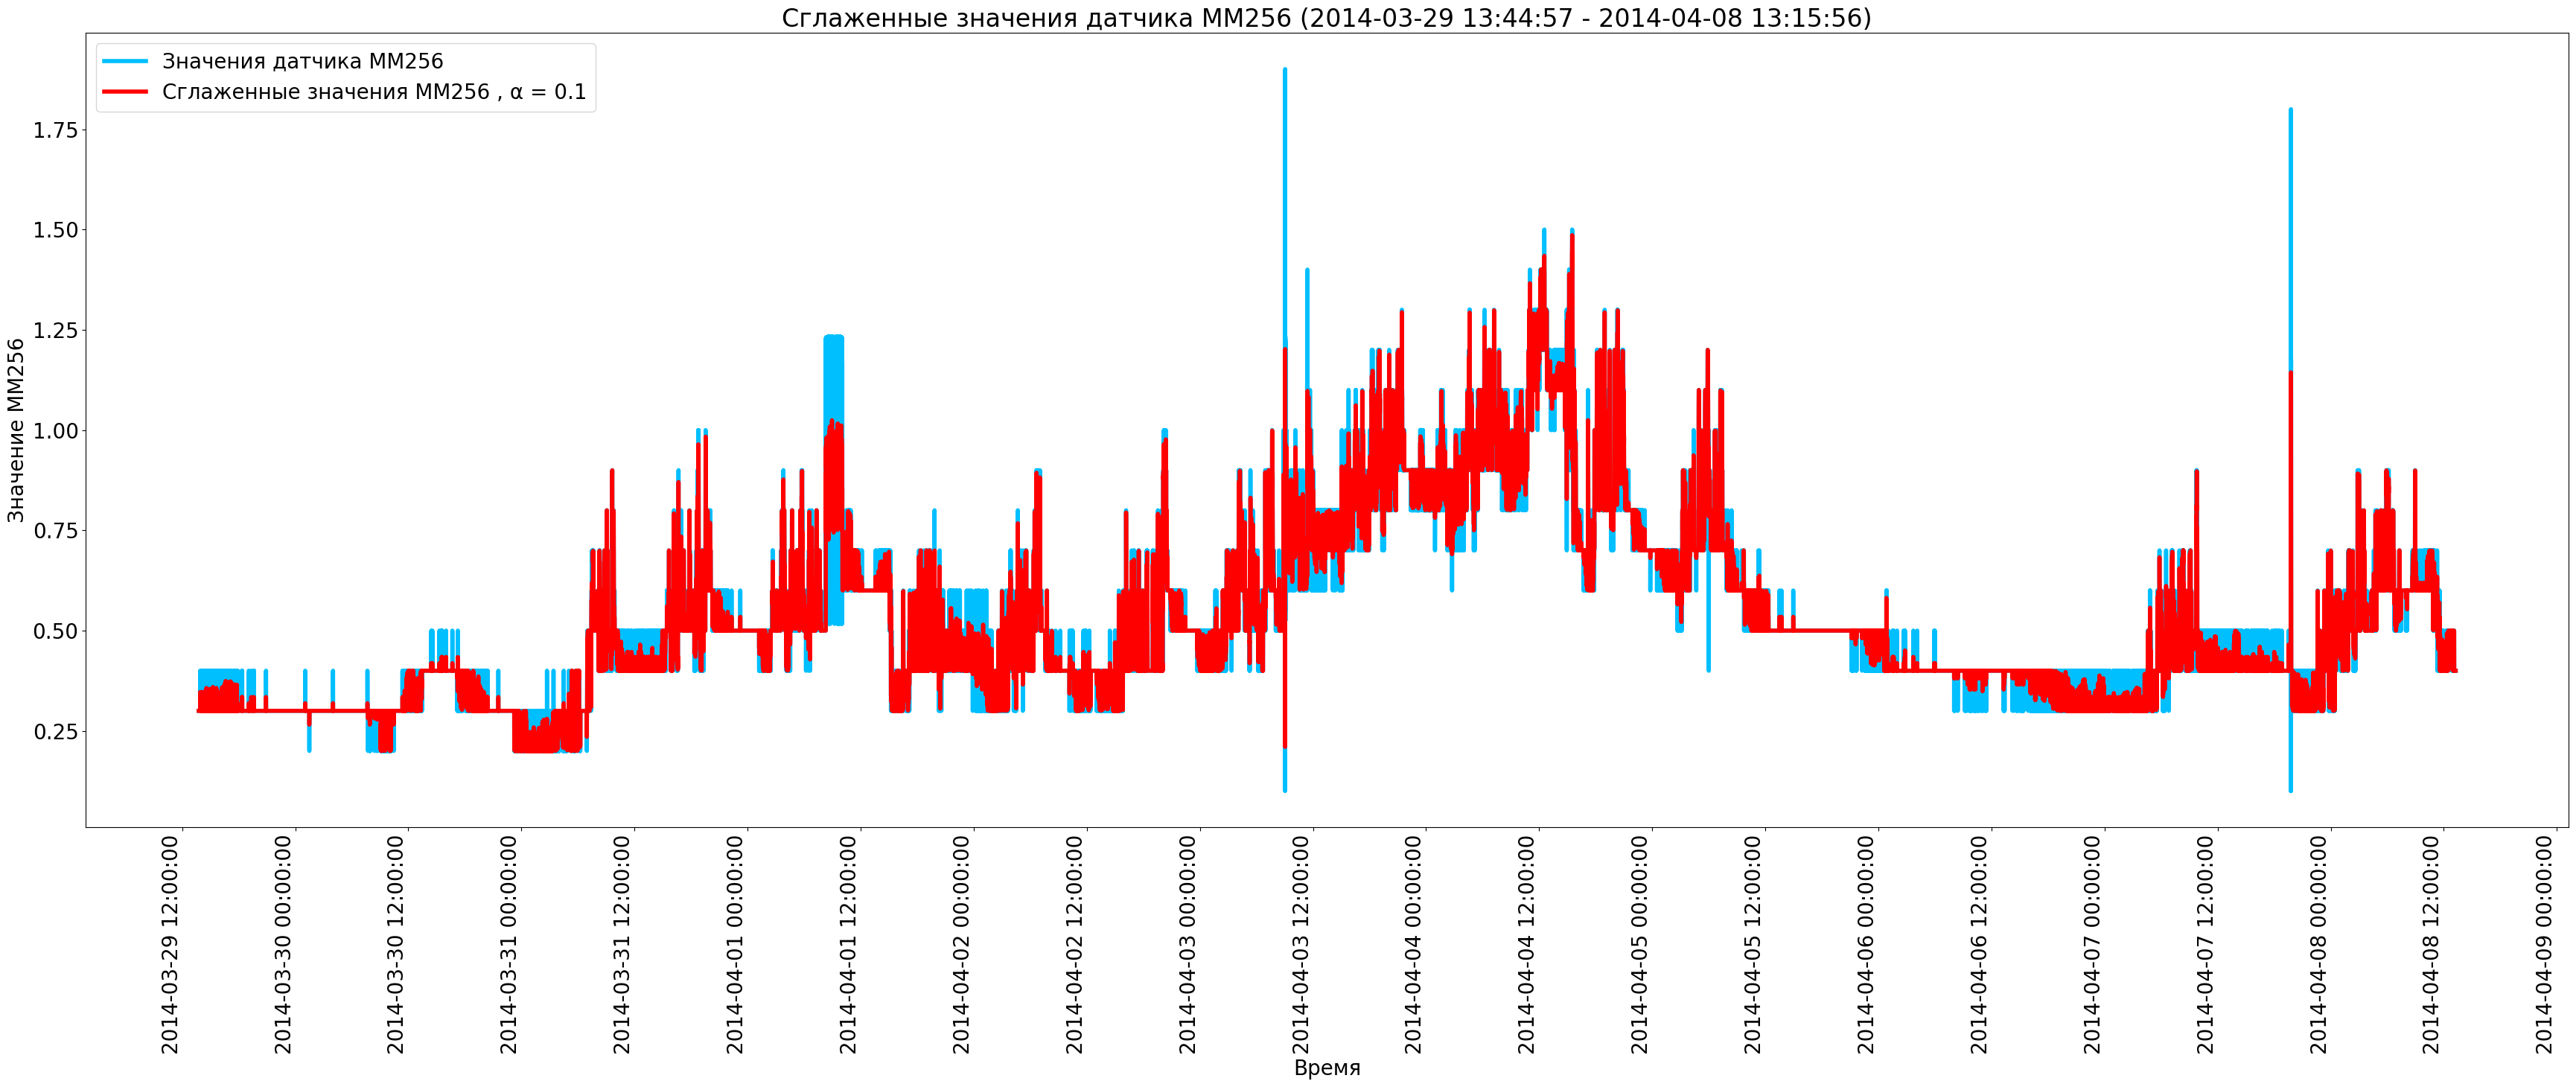

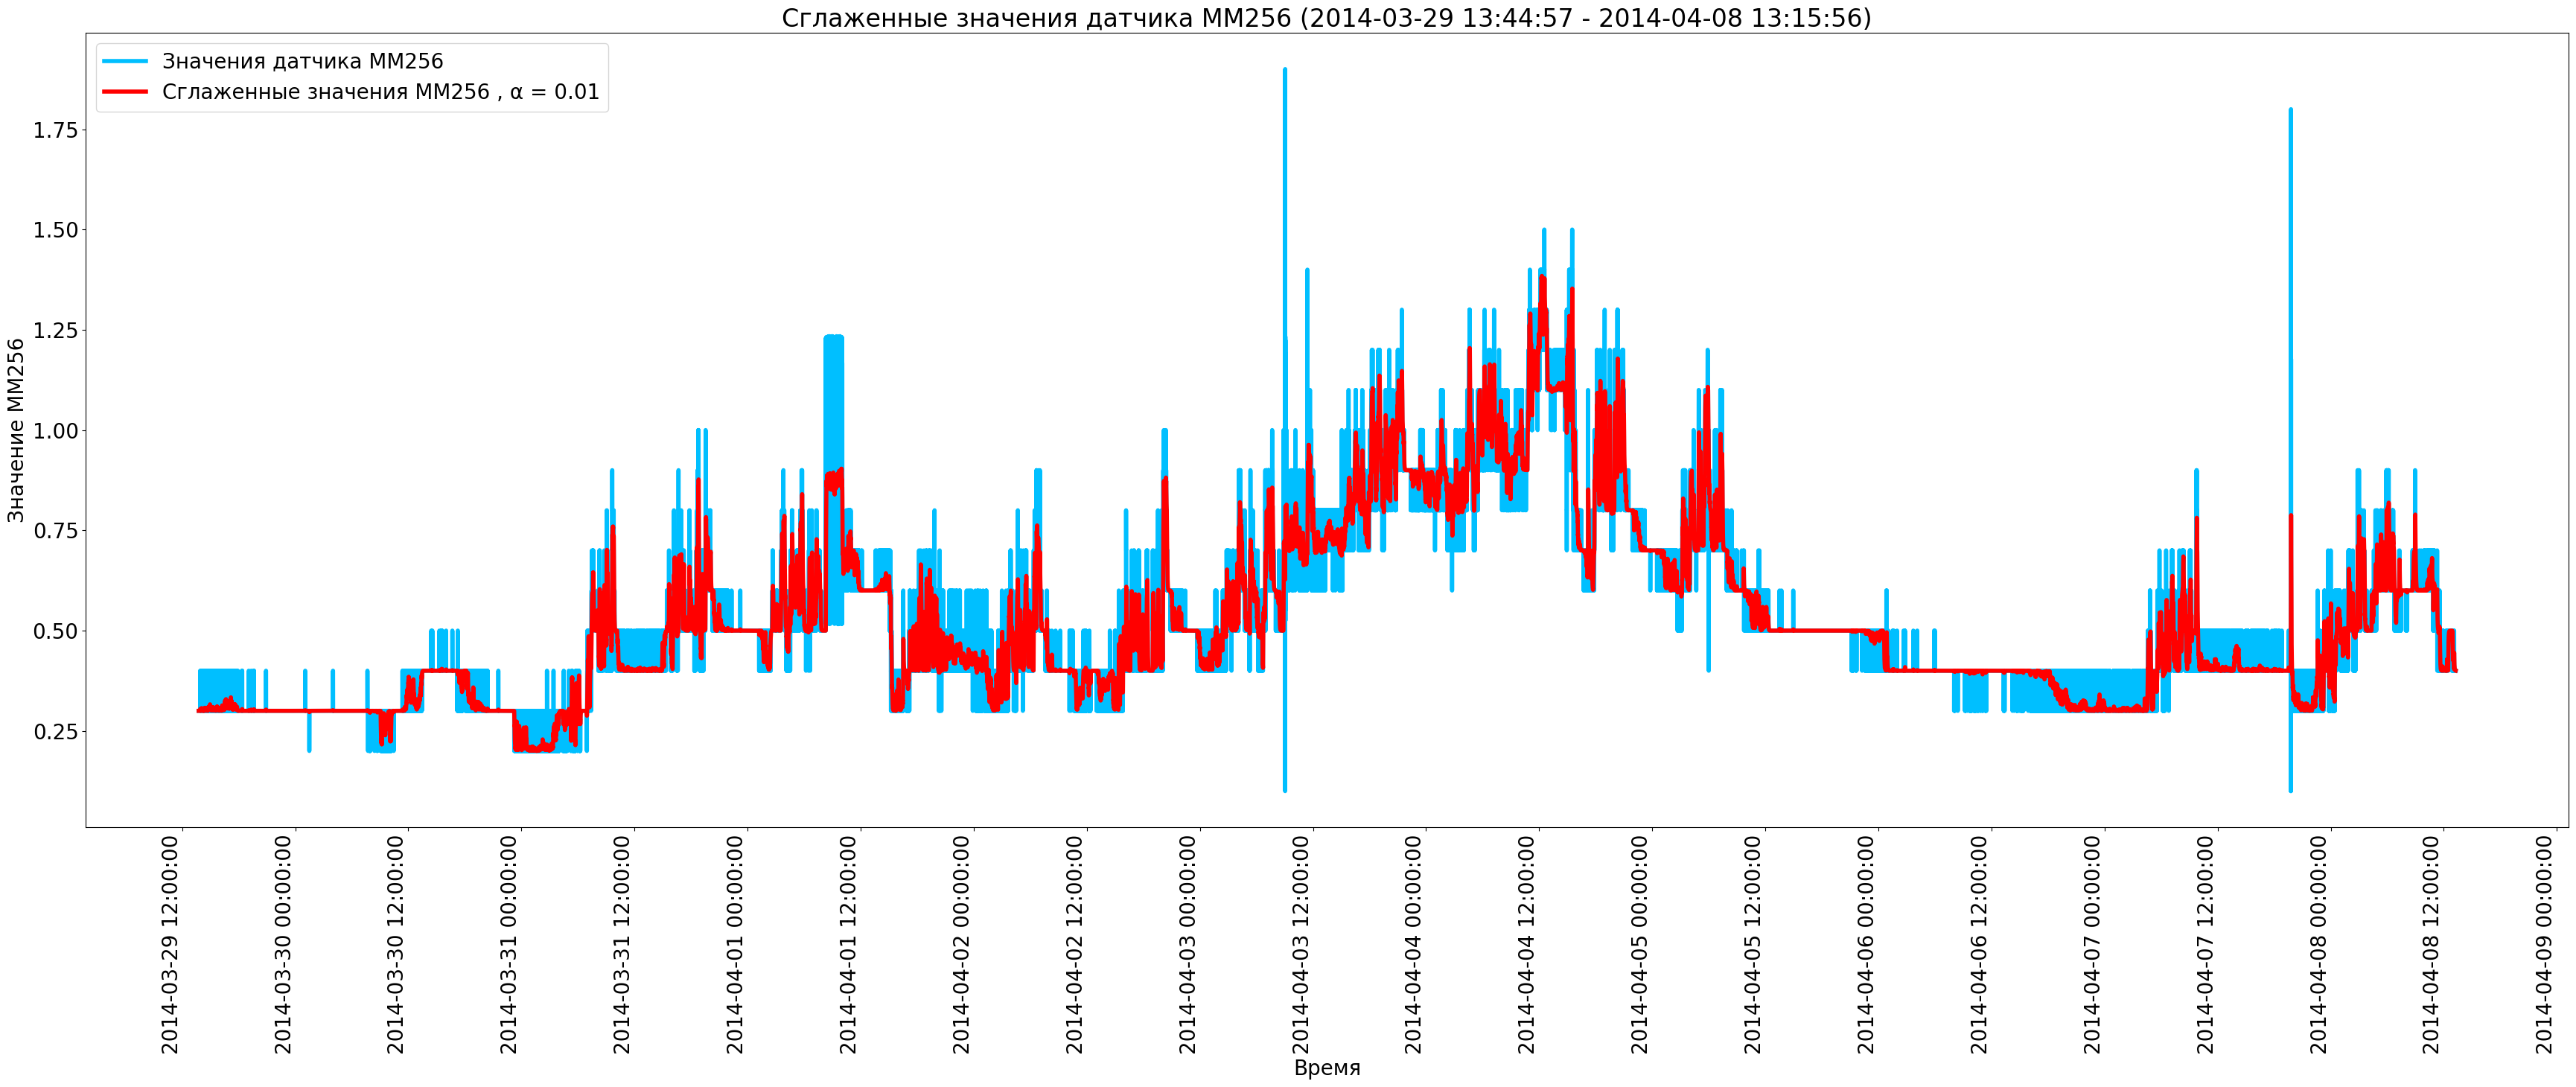

In [ ]:
# @title Загрузка набора данных, сглаживание значений  { vertical-output: false}

if __name__ == '__main__':
    data_set = pd.read_csv('https://dl.dropboxusercontent.com/scl/fi/owic046yzt8vp1byan552/ready.csv?rlkey=90xhxmnkmw5texpmxk0hwekgt&st=i707ooie&dl=0')

    data_set = swap_outliers(data_set, ['an311', 'an422', 'an423', 'tp1721', 'rh1722', 'tp1711', 'rh1712', 'p_864', 'tc862', 'wm868'])
    data_set = clean_ba1713(data_set, ['ba1723', 'ba1713'])
    data_set = clean_mm252(data_set, ['mm252', 'mm261', 'mm262', 'mm263', 'mm264', 'mm256', 'mm211', 'mm256_predicted'])
    data_set = clean_cm861(data_set, ['cm861'])
    data_set = clean_cr863(data_set, [ 'cr863'])
    data_set = clean_v(data_set, ['v'])

    alpha = 0.1
    smoothed_values = smooth_values(alpha, data_set, factors_added)
    plot_dataset_values(
            start_time,
            end_time,
            alpha,
            'mm256',
            'Сглаженные значения датчика',
            data_set,
            smoothed_values
        )

    alpha = 0.01
    smoothed_values = smooth_values(alpha, smoothed_values, factors_added)
    plot_dataset_values(
            start_time,
            end_time,
            alpha,
            'mm256',
            'Сглаженные значения датчика',
            data_set,
            smoothed_values
        )

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_features = scaler.fit_transform(smoothed_values[factors_added])

    scaled_data = pd.DataFrame(scaled_features, columns=factors_added)
    scaled_data = pd.concat([smoothed_values[['id', 'moment']], scaled_data], axis=1)

    train_data, test_data = train_test_split(scaled_data, test_size=0.3, random_state=42)

In [ ]:
# @title Создание и обучение сети  { vertical-output: false}

if __name__ == '__main__':
    mlp_regressor = MLPRegressor(
            hidden_layer_sizes=(114),
            activation='relu',
            solver='adam',
            max_iter=512,
            random_state=42434,
            verbose=True,
            tol=1e-9
        )

    mlp_regressor.fit(train_data[factors], train_data[target])

    trained_net_path = 'trained_net_2_28-114-1,relu.net'
    pickle.dump(mlp_regressor, open(trained_net_path, 'wb'))

Iteration 1, loss = 0.00124591
Iteration 2, loss = 0.00085751
Iteration 3, loss = 0.00076646
Iteration 4, loss = 0.00071067
Iteration 5, loss = 0.00066499
Iteration 6, loss = 0.00062727
Iteration 7, loss = 0.00060293
Iteration 8, loss = 0.00057990
Iteration 9, loss = 0.00055708
Iteration 10, loss = 0.00053869
Iteration 11, loss = 0.00051907
Iteration 12, loss = 0.00051025
Iteration 13, loss = 0.00049558
Iteration 14, loss = 0.00048659
Iteration 15, loss = 0.00047881
Iteration 16, loss = 0.00046719
Iteration 17, loss = 0.00045910
Iteration 18, loss = 0.00045316
Iteration 19, loss = 0.00044599
Iteration 20, loss = 0.00043940
Iteration 21, loss = 0.00043222
Iteration 22, loss = 0.00042783
Iteration 23, loss = 0.00042488
Iteration 24, loss = 0.00041945
Iteration 25, loss = 0.00041589
Iteration 26, loss = 0.00040894
Iteration 27, loss = 0.00040840
Iteration 28, loss = 0.00040273
Iteration 29, loss = 0.00040061
Iteration 30, loss = 0.00039671
Iteration 31, loss = 0.00039378
Iteration 32, los

In [ ]:
# @title Оценка сети { vertical-output: false}

if __name__ == '__main__':
    trained_net_path = 'trained_net_2_28-114-1,relu.net'
    loaded_mlp_regressor = pickle.load(open(trained_net_path, 'rb'))

    y_pred = loaded_mlp_regressor.predict(test_data[factors])

    print(f"Коэффициент детерминации R² = {r2_score(test_data[target], y_pred)}")
    print(f"Среднеквадратичная ошибка MSE: {mean_squared_error(test_data[target], y_pred)}")
    print(f"Корень из среднеквадратичной ошибки RMSE: {root_mean_squared_error(test_data[target], y_pred)}")
    print(f"Cредняя абсолютная ошибка MAE: {mean_absolute_error(test_data[target], y_pred)}")
    print(f"Средняя абсолютная процентная ошибка MAPE: {mean_absolute_percentage_error(test_data[target], y_pred)} ({100 * mean_absolute_percentage_error(test_data[target], y_pred)} %)")

Коэффициент детерминации R² = 0.9716294942933174
Среднеквадратичная ошибка MSE: 0.0009217283055988268
Корень из среднеквадратичной ошибки RMSE: 0.030359978682450137
Cредняя абсолютная ошибка MAE: 0.021074182038077535
Средняя абсолютная процентная ошибка MAPE: 0.208310331596002 (20.831033159600203 %)


In [ ]:
# @title Составление прогноза

if __name__ == '__main__':
    data_set = pd.read_csv('https://dl.dropboxusercontent.com/scl/fi/owic046yzt8vp1byan552/ready.csv?rlkey=90xhxmnkmw5texpmxk0hwekgt&st=i707ooie&dl=0')
    data_set = swap_outliers(data_set, ['an311', 'an422', 'an423', 'tp1721', 'rh1722', 'tp1711', 'rh1712', 'p_864', 'tc862', 'wm868'])
    data_set = clean_ba1713(data_set, ['ba1723', 'ba1713'])
    data_set = clean_mm252(data_set, ['mm252', 'mm261', 'mm262', 'mm263', 'mm264', 'mm256', 'mm211', 'mm256_predicted'])
    data_set = clean_cm861(data_set, ['cm861'])
    data_set = clean_cr863(data_set, [ 'cr863'])
    data_set = clean_v(data_set, ['v'])
    alpha = 0.1
    smoothed_values_new = smooth_values(alpha, data_set, factors_added)
    alpha = 0.01
    smoothed_values_new = smooth_values(alpha, smoothed_values_new, factors_added)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data_new = pd.DataFrame(smoothed_values_new[factors])
    scaled_data_new['mm256_forecast'] = smoothed_values_new['mm256_predicted']
    scaled_data_new = pd.DataFrame(scaler.fit_transform(scaled_data_new[factors_new]), columns=factors_new)
    mm256_forecast = pd.DataFrame(loaded_mlp_regressor.predict(scaled_data_new[factors]))
    scaled_data_new['mm256_forecast'] = mm256_forecast

    scaled_data_new = pd.DataFrame(scaler.inverse_transform(scaled_data_new), columns=factors_new)
    scaled_data_new = pd.concat([smoothed_values_new[['id', 'moment', 'mm256_predicted']], scaled_data_new], axis=1)

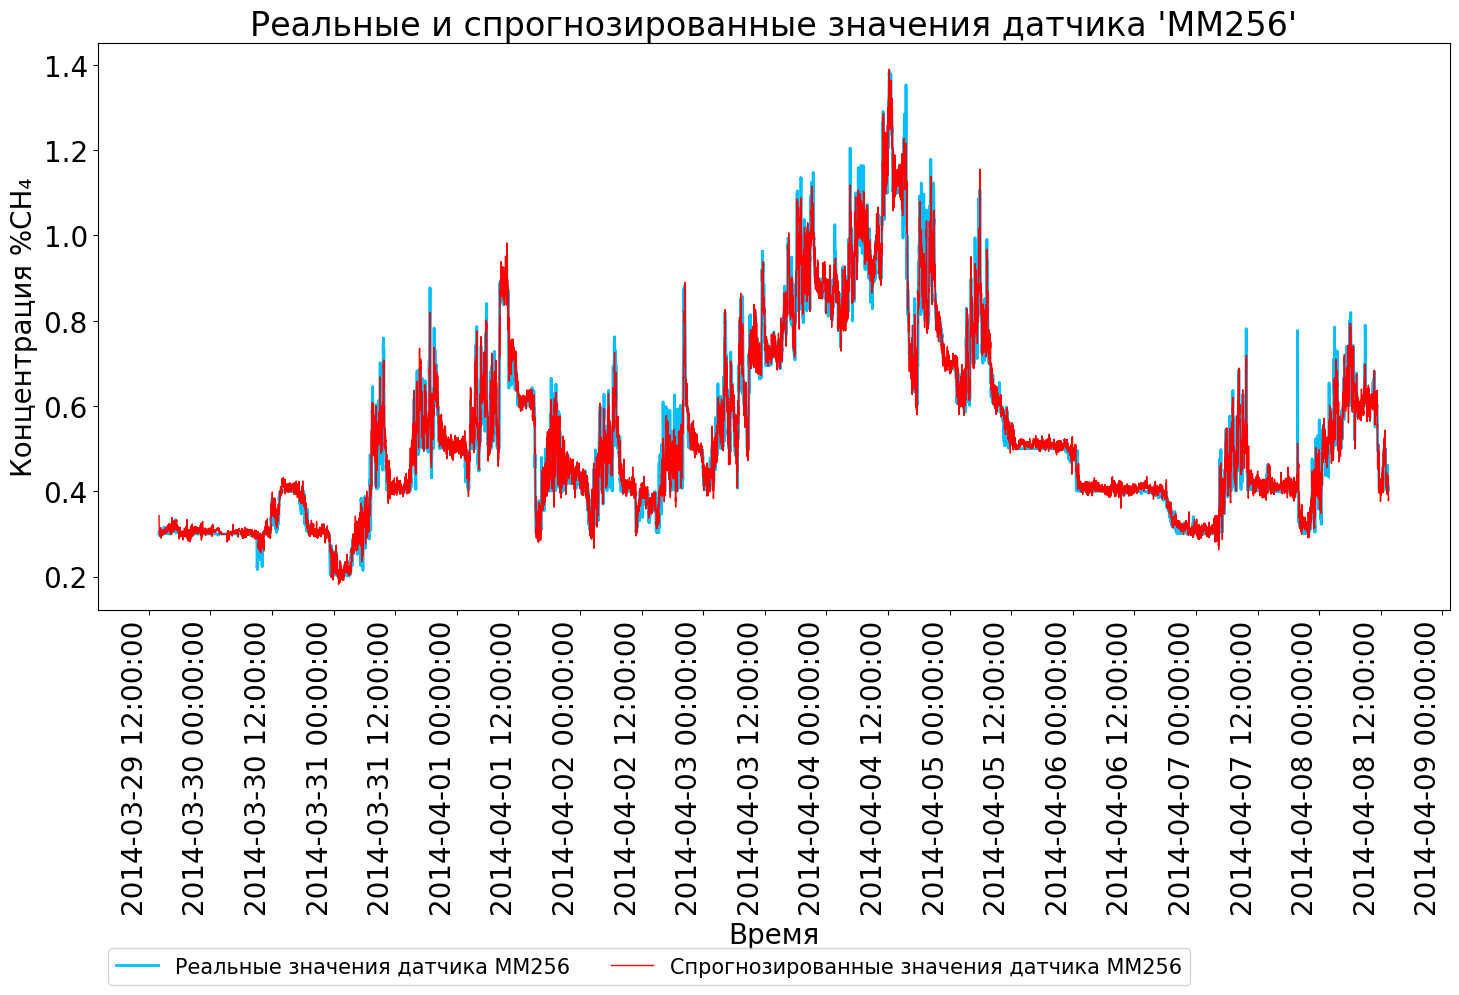

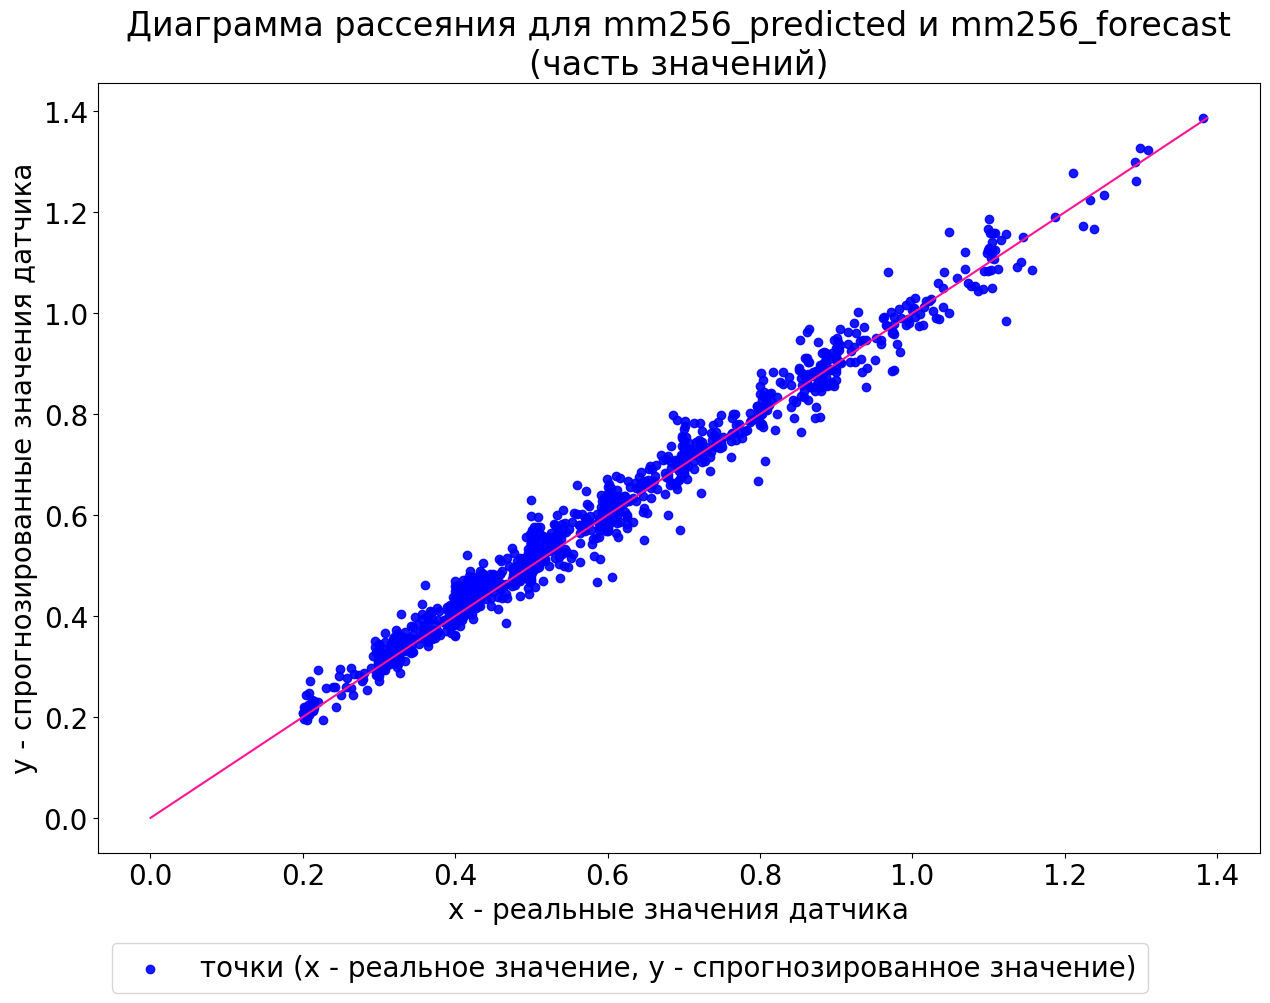

In [ ]:
# @title Вывод графиков

if __name__ == '__main__':
    plot_forecasted_values('mm256_predicted', 'mm256_forecast', scaled_data_new, start_time, end_time)
    plot_scatter(scaled_data_new)

In [ ]:
# @title Загрузка обученных сетей { vertical-output: false}

net_example_1 = get_net('https://dl.dropboxusercontent.com/scl/fi/octziifgu0eb1d6v08wza/trained_net_2_28-114-1-relu.net?rlkey=0og2283phg693nxi94lm9r612&st=wdcmzdmc&dl=0', 'trained_net_2_28-114-1,relu.net')